# Artificial Neural Networks and Deep Learning

---

## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

%pip install keras-cv
import keras_cv
import keras

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
from tensorflow import data as tf_data
import cv2
import pandas as pd
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## ⏳ Load the Data

In [ ]:
data = np.load('/kaggle/input/balanced-augmented-dataset0-1/balanced_augmented_dataset(0_1).npz')
X_train_val = data['images']
y_train_val = data['labels']

label_names = {
0: 'Basophil',
1: 'Eosinophil',
2: 'Erythroblast',
3: 'Immature granulocytes',
4: 'Lymphocyte',
5: 'Monocyte',
6: 'Neutrophil',
7: 'Platele'
}

print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Inspect the target
print('Counting occurrences of target classes:')
y_train_val_labels = np.argmax(y_train_val, axis=1)  # Get the index of the maximum value in each row
print(pd.DataFrame(y_train_val_labels, columns=['digit'])['digit'].value_counts())

Training-Validation Data Shape: (51943, 96, 96, 3)
Training-Validation Label Shape: (51943, 8)
Counting occurrences of target classes:
digit
6    7355
1    7154
3    7043
7    6642
2    6066
5    5985
0    5867
4    5831
Name: count, dtype: int64


## 🔎 Inspect Data

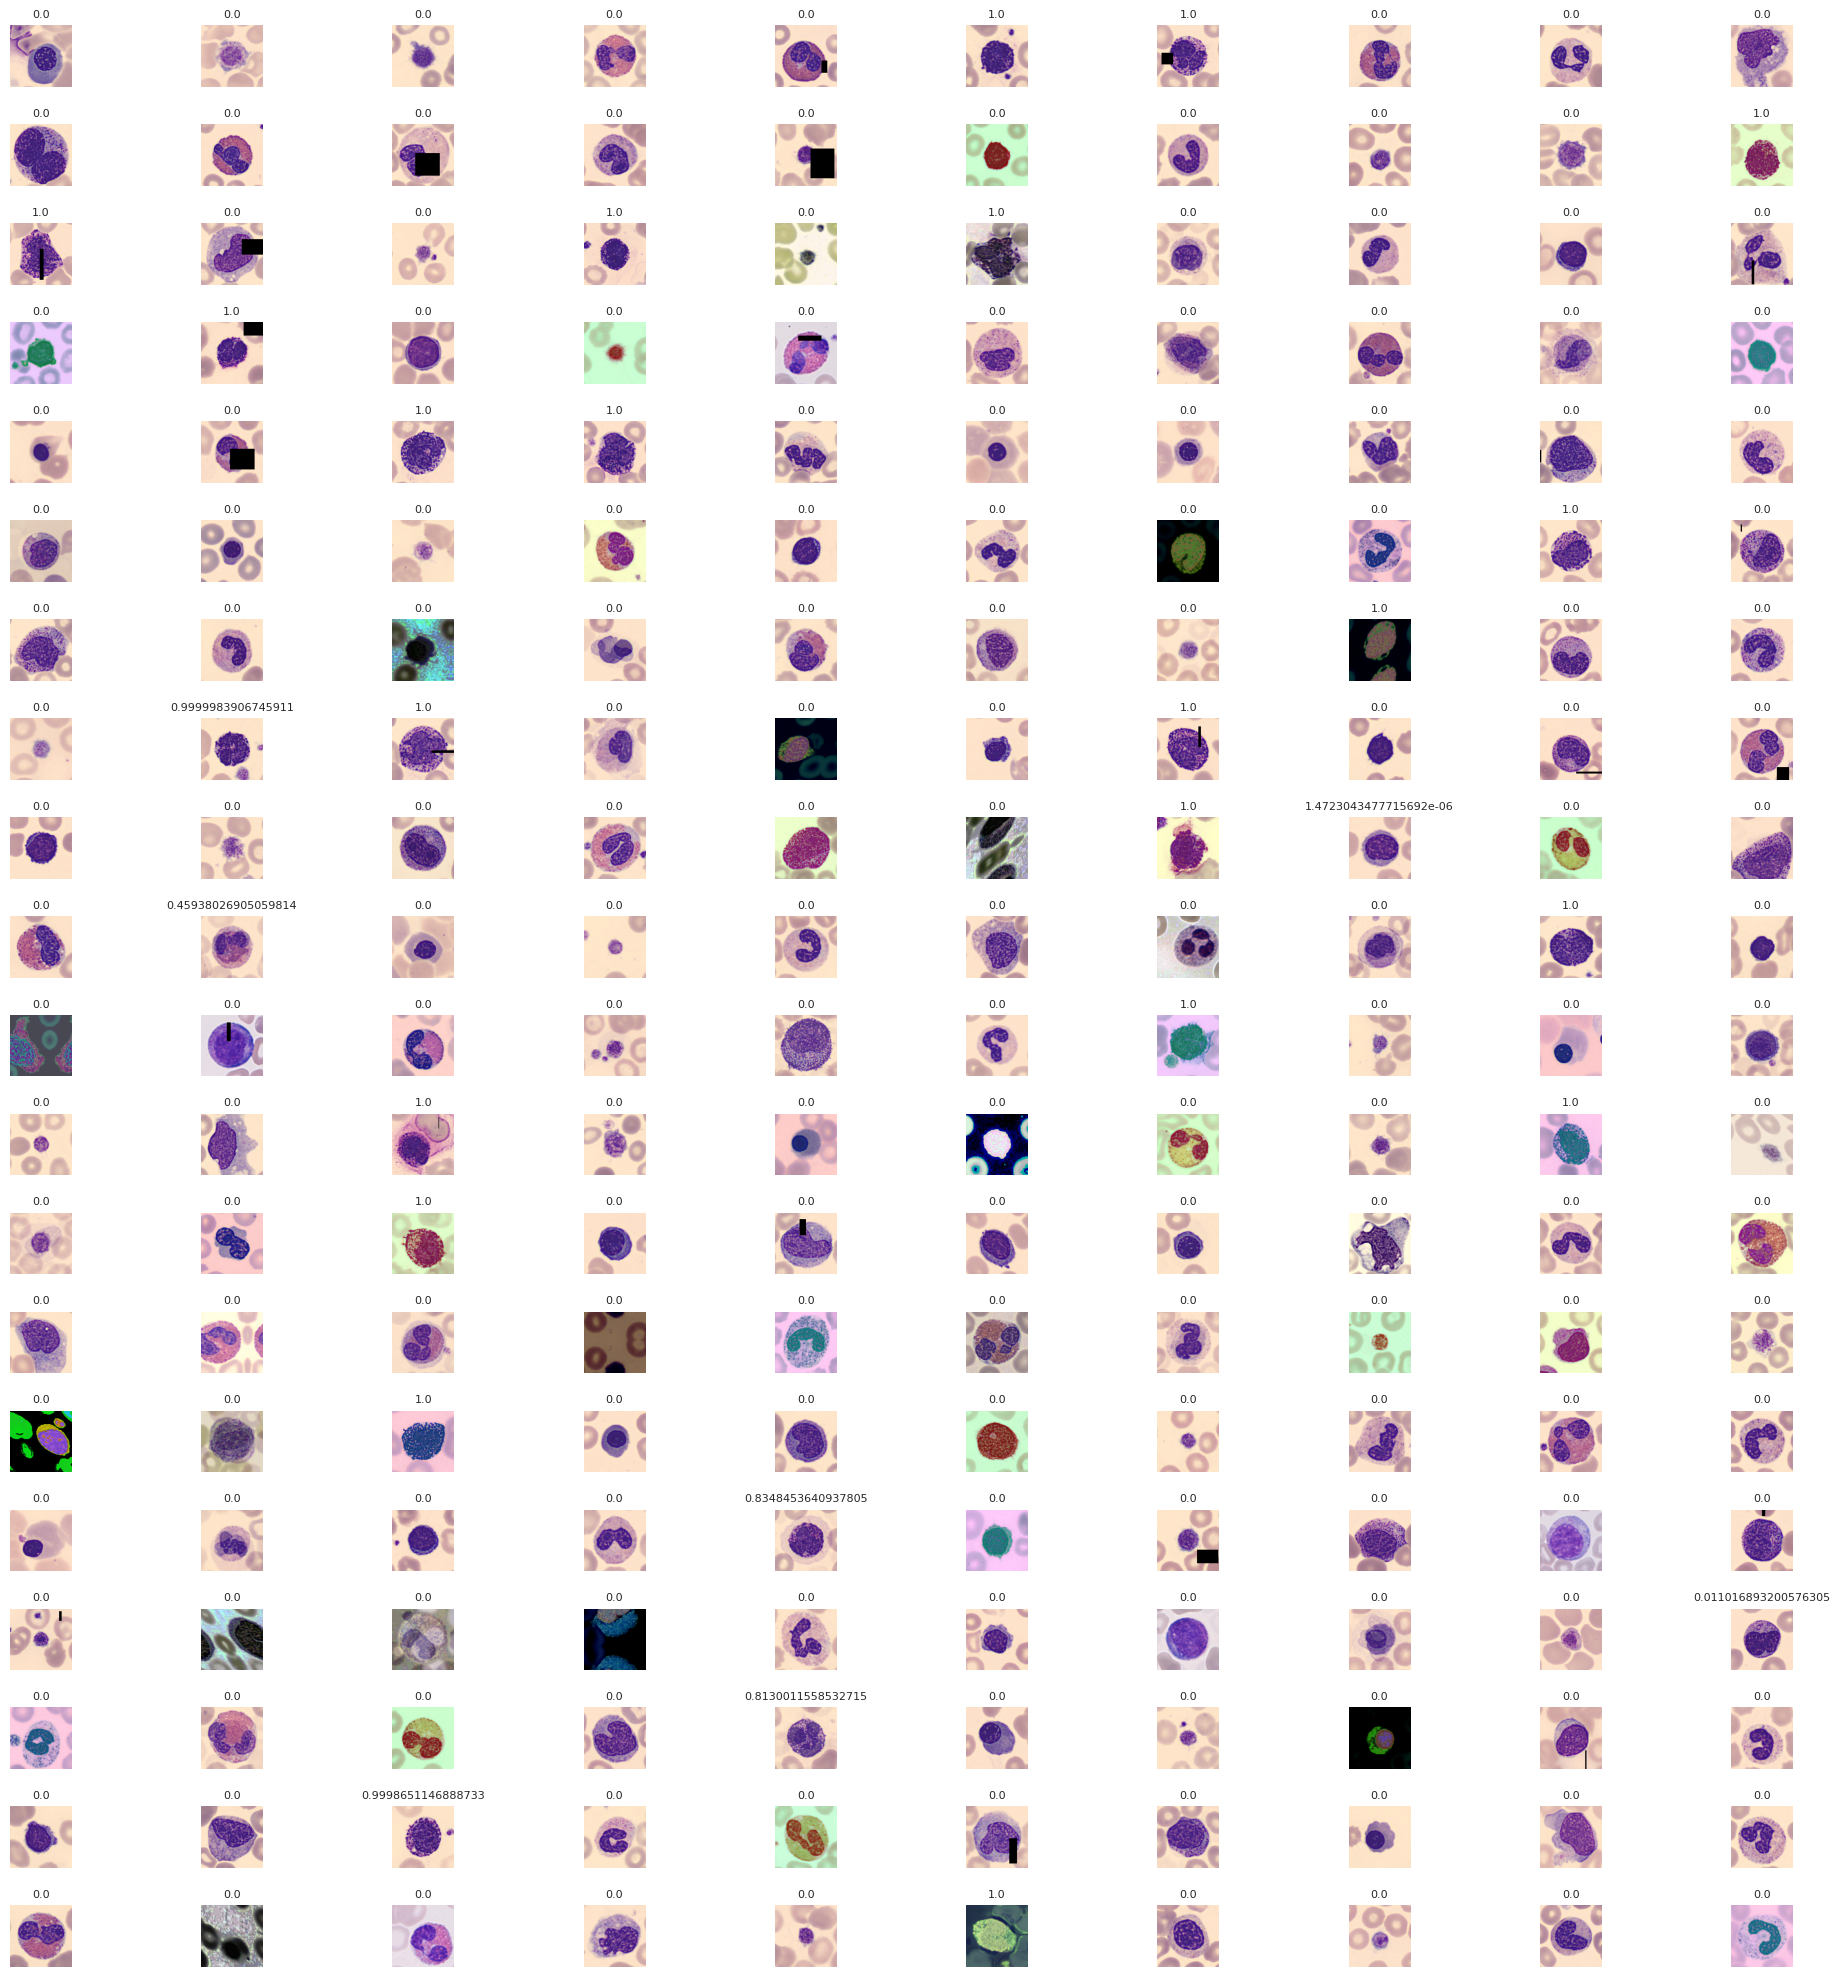

In [ ]:
# Set parameters for visualization
num_images = 200  # Total number of images to display
images_per_row = 10  # Number of images per row
random_indices = random.sample(range(len(X_train_val)), num_images)

# Create a grid of subplots
fig, axes = plt.subplots(
    num_images // images_per_row,
    images_per_row,
    figsize=(20, 20)
)

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_train_val[idx][0]}', fontsize=8)
    ax.axis('off')

# Hide unused axes if any
for ax in axes[num_images:]:
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 🔄 Process Data

In [ ]:
# split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1)

# print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

# de-normalize dataset
X_train *= 255
X_val *= 255

Training Data Shape: (46748, 96, 96, 3)
Training Label Shape: (46748, 8)
Validation Data Shape: (5195, 96, 96, 3)
Validation Label Shape: (5195, 8)


## 🧮 Define Network Parameters

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 1e-4

# Dropout rate
dropout_rate = 0.5

# Define the patience value for early stopping
patience = 5

## 🛠️ Build the Model

In [ ]:
# Automatically sets all layers to use float16 computations wherever possible
tfk.mixed_precision.set_global_policy('mixed_float16')

convbase = tfk.applications.ConvNeXtBase(
    input_shape=(96, 96, 3),
    input_tensor=None,
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
def build_tl_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    seed=seed
):

  tf.random.set_seed(seed)

  # Define input layer with shape matching the input images
  inputs = tfk.Input(shape=input_shape, name='input_layer')

  # Augmentation
  augmentation = tf.keras.Sequential([
      tfkl.RandomFlip("horizontal_and_vertical"),
      tfkl.RandomBrightness(0.2),
      tfkl.RandomRotation((-1,1)),
      tfkl.RandomTranslation((-0.2, 0.2),(-0.2,0.2)),
      tfkl.RandomContrast(0.2)], name='preprocessing')

  x = augmentation(inputs)

  x = convbase(x)

  # FC (Fully Connected) - only trainable part
  x = tfkl.Dense(units=512, name='dense1')(x)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Activation('relu', name='act1')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed, name='dropout1')(x)

  x = tfkl.Dense(units=128, name='dense2')(x)
  x = tfkl.Activation('relu', name='act2')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed, name='dropout2')(x)

  x = tfkl.Dense(units=output_shape, name='dense3')(x)
  outputs = tfkl.Activation('softmax', name='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ preprocessing (Sequential)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip            │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation        │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation     │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast        │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_base (Functional)  │ (None, 1024)          │ 87,566,464 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 96, 96, 3)     │          0 │   -   │
│ convnext_base_prestem_norm… │                       │            │       │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ convnext_base_stem     │ (None, 24, 24, 128)   │      6,528 │   Y   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │      6,272 │   Y   │
│ convnext_base_stem_conv     │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │        256 │   Y   │
│ convnext_base_stem_layerno… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │      6,400 │   Y   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        256 │   Y   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │     66,048 │   Y   │
│ convnext_base_stage_0_bloc… │                       │            │     

 Total params: 88,160,008 (336.30 MB)

 Trainable params: 88,158,984 (336.30 MB)

 Non-trainable params: 1,024 (4.00 KB)

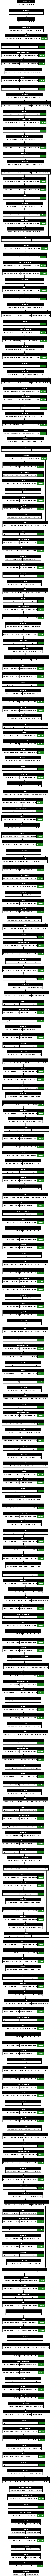

In [ ]:
# Build the model with specified input and output shapes
tl_model = build_tl_model()

# Display a summary of the model architecture
tl_model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🧠 Train and Save the Model

In [ ]:
# freeze weights
for layer in convbase.layers:
  layer.trainable = False

# Compile the model with Categorical Cross-Entropy loss and Lion optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Lion(learning_rate), metrics=['accuracy'])

# Train model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

tl_model.save('weights.keras')

Epoch 1/50


I0000 00:00:1732309969.092948      77 service.cc:145] XLA service 0x7de1670019f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732309969.093002      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732309969.402709      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


366/366 ━━━━━━━━━━━━━━━━━━━━ 184s 439ms/step - accuracy: 0.4941 - loss: 1.6009 - val_accuracy: 0.8572 - val_loss: 0.4763
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 412ms/step - accuracy: 0.8226 - loss: 0.5989 - val_accuracy: 0.9013 - val_loss: 0.3606
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 412ms/step - accuracy: 0.8562 - loss: 0.5093 - val_accuracy: 0.9143 - val_loss: 0.3242
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 412ms/step - accuracy: 0.8647 - loss: 0.4709 - val_accuracy: 0.9153 - val_loss: 0.3135
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 412ms/step - accuracy: 0.8748 - loss: 0.4433 - val_accuracy: 0.9155 - val_loss: 0.3119
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 411ms/step - accuracy: 0.8824 - loss: 0.4263 - val_accuracy: 0.9182 - val_loss: 0.2963
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 412ms/step - accuracy: 0.8870 - loss: 0.4080 - val_accuracy: 0.9217 - val_loss: 0.2969
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 151s 411ms/step - accuracy: 0.8858 - loss: 0.40

## 🧠 Fine Tuning

In [ ]:
tl_model.load_weights('weights.keras')

#unfreeze weights
for layer in convbase.layers:
    layer.trainable = True

# Compile the model with Categorical Cross-Entropy loss and Lion optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Lion(1e-6), metrics=['accuracy'])

# Fine-tune the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

tl_model.save('weights.keras')

# Delete the model to free up resources
del tl_model

Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - accuracy: 0.9226 - loss: 0.3070 - val_accuracy: 0.9571 - val_loss: 0.1988
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9482 - loss: 0.2357 - val_accuracy: 0.9673 - val_loss: 0.1745
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9571 - loss: 0.2065 - val_accuracy: 0.9704 - val_loss: 0.1647
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9601 - loss: 0.1933 - val_accuracy: 0.9738 - val_loss: 0.1526
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9651 - loss: 0.1794 - val_accuracy: 0.9750 - val_loss: 0.1494
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9690 - loss: 0.1686 - val_accuracy: 0.9759 - val_loss: 0.1403
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9710 - loss: 0.1604 - val_accuracy: 0.9748 - val_loss: 0.1396
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9733 - loss: 0.1567 - val_accu

## 📊 Plotting Statistics

### Fine Tuning

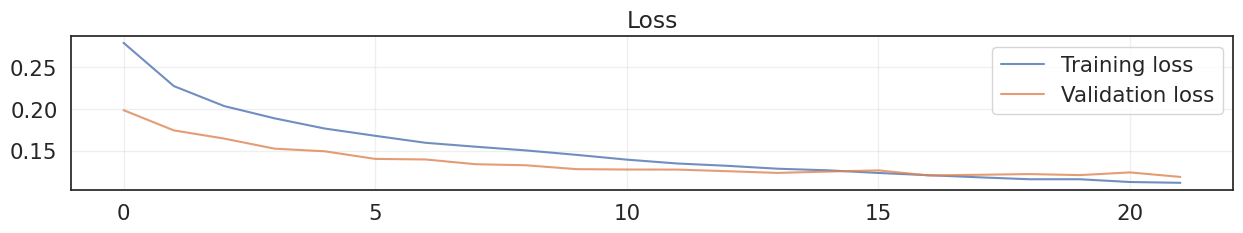

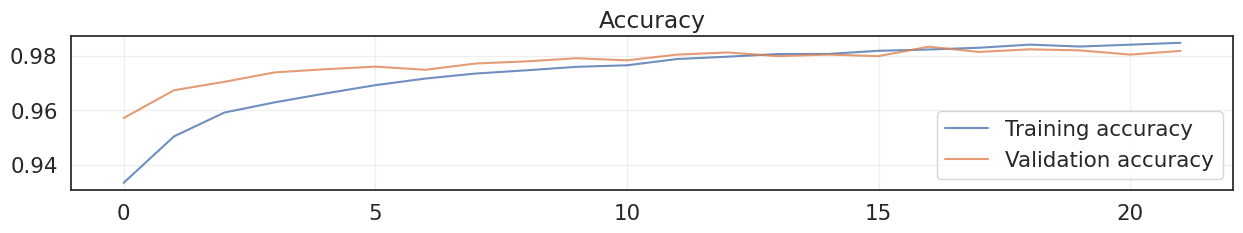

In [ ]:
# Plot training and validation loss. You can see that there is overfitting
plt.figure(figsize=(15, 2))
plt.plot(tl_history['loss'], label='Training loss', alpha=.8)
plt.plot(tl_history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(tl_history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step
Accuracy score over the test set: 0.9833
Precision score over the test set: 0.9833
Recall score over the test set: 0.9833
F1 score over the test set: 0.9832


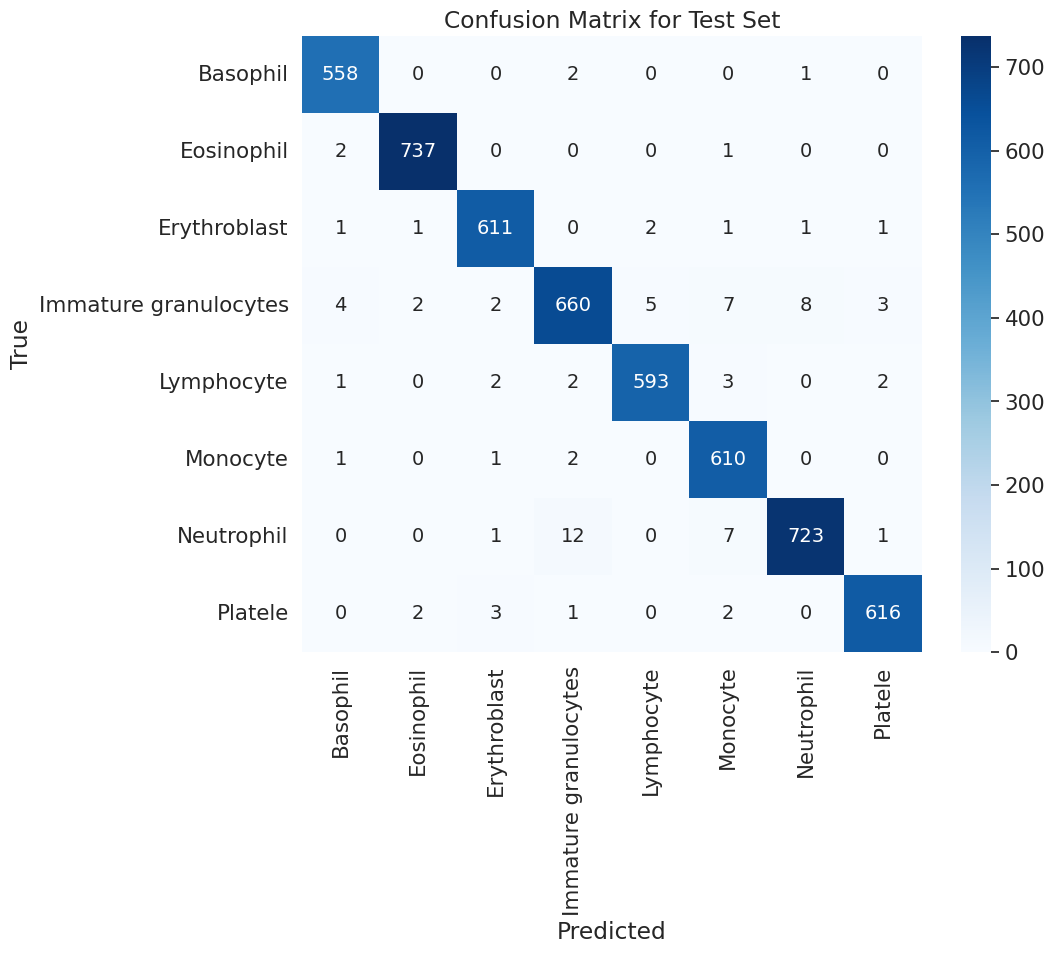

In [ ]:
tl_model = keras.saving.load_model('/kaggle/working/weights.keras')

# confusion matrix over the validation set
preds = tl_model.predict(X_val)
y_test_pred = np.argmax(preds, axis=1)
y_test_numerical = np.argmax(y_val, axis=1)

# Convert predictions to class labels
pred_classes = np.argmax(preds, axis=-1)
# Extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)
# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')
# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')
# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')
# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

conf_matrix = confusion_matrix(y_test_numerical, y_test_pred)
labels = list(label_names.values())
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

%cd /kaggle/working
from IPython.display import FileLink
FileLink(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 6%)
/kaggle/working


/kaggle/working/submission_241123_020840.zip